<a href="https://colab.research.google.com/github/zahranicp/hands-on-ML2/blob/main/chapter07/Chapter_07_ensemble_learning_and_random_forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade xgboost==2.1.1
!pip install scikit-learn==1.6.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 5.7 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 3.1.2
    Uninstalling xgboost-3.1.2:
      Successfully uninstalled xgboost-3.1.2


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

# Dataset "bulan sabit" dengan noise
X, y = make_moons(n_samples=500, noise=0.3, random_state=123)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=123)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Menggunakan tiga model berbeda
model_lr = LogisticRegression(solver="lbfgs", random_state=123)
model_rf = RandomForestClassifier(n_estimators=100, random_state=123)
model_svc = SVC(gamma="scale", random_state=123)


In [ ]:
from sklearn.ensemble import VotingClassifier

# Kombinasi ketiga model ke dalam voting classifier
voting_hard = VotingClassifier(
    estimators=[
        ("logreg", model_lr),
        ("randomforest", model_rf),
        ("svc", model_svc)
    ],
    voting="hard"
)

voting_hard.fit(X_train, y_train)


VotingClassifier(estimators=[('logreg', LogisticRegression(random_state=123)),
                             ('randomforest',
                              RandomForestClassifier(random_state=123)),
                             ('svc', SVC(random_state=123))])

In [ ]:
from sklearn.metrics import accuracy_score

for model in (model_lr, model_rf, model_svc, voting_hard):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{model.__class__.__name__} -> Akurasi: {acc:.4f}")


LogisticRegression -> Akurasi: 0.8560
RandomForestClassifier -> Akurasi: 0.9200
SVC -> Akurasi: 0.9040
VotingClassifier -> Akurasi: 0.9040


In [ ]:
# Buat ulang model SVC agar bisa hitung probabilitas
model_svc_soft = SVC(gamma="scale", probability=True, random_state=123)

voting_soft = VotingClassifier(
    estimators=[
        ("logreg", model_lr),
        ("randomforest", model_rf),
        ("svc", model_svc_soft)
    ],
    voting="soft"
)

voting_soft.fit(X_train, y_train)

# Evaluasi kembali
for model in (model_lr, model_rf, model_svc_soft, voting_soft):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{model.__class__.__name__} (soft) -> Akurasi: {accuracy_score(y_test, y_pred):.4f}")


LogisticRegression (soft) -> Akurasi: 0.8560
RandomForestClassifier (soft) -> Akurasi: 0.9200
SVC (soft) -> Akurasi: 0.9040
VotingClassifier (soft) -> Akurasi: 0.9200


In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Model pohon tunggal
tree_single = DecisionTreeClassifier(random_state=123)
tree_single.fit(X_train, y_train)

# Model bagging (500 tree, subset 100 sampel, bootstrap=True)
bagging_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=123),  # <- di sini
    n_estimators=500,
    max_samples=100,
    bootstrap=True,
    n_jobs=-1,
    random_state=123
)
bagging_model.fit(X_train, y_train)


BaggingClassifier(estimator=DecisionTreeClassifier(random_state=123),
                  max_samples=100, n_estimators=500, n_jobs=-1,
                  random_state=123)

In [ ]:
from sklearn.metrics import accuracy_score

# Evaluasi kedua model
pred_tree = tree_single.predict(X_test)
pred_bagging = bagging_model.predict(X_test)

print(f"Akurasi DecisionTree: {accuracy_score(y_test, pred_tree):.4f}")
print(f"Akurasi Bagging Tree:  {accuracy_score(y_test, pred_bagging):.4f}")


Akurasi DecisionTree: 0.8960
Akurasi Bagging Tree:  0.9280


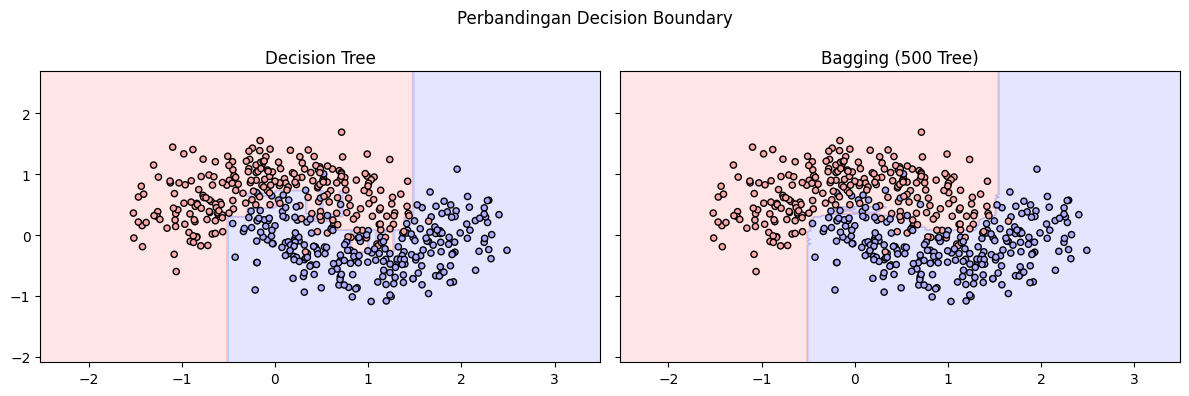

In [ ]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def tampilkan_boundary(model, X, y, ax, title="Model"):
    cmap_bold = ListedColormap(["#FFAAAA", "#AAAAFF"])
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, cmap=cmap_bold, alpha=0.3)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor="k", s=20)
    ax.set_title(title)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
tampilkan_boundary(tree_single, X, y, ax=axes[0], title="Decision Tree")
tampilkan_boundary(bagging_model, X, y, ax=axes[1], title="Bagging (500 Tree)")
plt.suptitle("Perbandingan Decision Boundary")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Model bagging dengan OOB score
bagging_oob = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=123),
    n_estimators=500,
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    random_state=40  # random_state dibedakan dari sebelumnya
)

bagging_oob.fit(X_train, y_train)


BaggingClassifier(estimator=DecisionTreeClassifier(random_state=123),
                  n_estimators=500, n_jobs=-1, oob_score=True, random_state=40)

In [ ]:
from sklearn.metrics import accuracy_score

print(f"OOB Score: {bagging_oob.oob_score_:.4f}")

# Bandingkan dengan test set
y_pred_oob = bagging_oob.predict(X_test)
test_acc = accuracy_score(y_test, y_pred_oob)
print(f"Akurasi di test set: {test_acc:.4f}")


OOB Score: 0.9227
Akurasi di test set: 0.9200


In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(
    n_estimators=500,
    max_leaf_nodes=16,
    random_state=123
)

forest_clf.fit(X_train, y_train)


RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, random_state=123)

In [ ]:
# Prediksi test set
y_pred_forest = forest_clf.predict(X_test)

# Bandingkan dengan BaggingClassifier
print(f"Akurasi Random Forest: {accuracy_score(y_test, y_pred_forest):.4f}")


Akurasi Random Forest: 0.9280


In [ ]:
# Buat model bagging yang mendekati struktur Random Forest
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import numpy as np

bag_clone = BaggingClassifier(
    estimator=DecisionTreeClassifier(
        max_features="sqrt",  # random feature subset
        max_leaf_nodes=16
    ),
    n_estimators=500,
    n_jobs=-1,
    random_state=123
)
bag_clone.fit(X_train, y_train)

# Bandingkan hasil prediksi
y_pred_bag = bag_clone.predict(X_test)
same_preds = np.mean(y_pred_bag == y_pred_forest)
print(f"Kesamaan prediksi Bagging vs RF: {same_preds:.4f}")


Kesamaan prediksi Bagging vs RF: 1.0000


In [ ]:
from sklearn.datasets import load_iris

# Load data Iris
iris = load_iris()
X_iris = iris.data
y_iris = iris.target


In [ ]:
# Model Random Forest
rf_iris = RandomForestClassifier(n_estimators=500, random_state=123)
rf_iris.fit(X_iris, y_iris)

# Tampilkan skor importance
for nama_fitur, skor in zip(iris.feature_names, rf_iris.feature_importances_):
    print(f"{nama_fitur:<25} : {skor:.4f}")


sepal length (cm)         : 0.0938
sepal width (cm)          : 0.0241
petal length (cm)         : 0.4588
petal width (cm)          : 0.4233


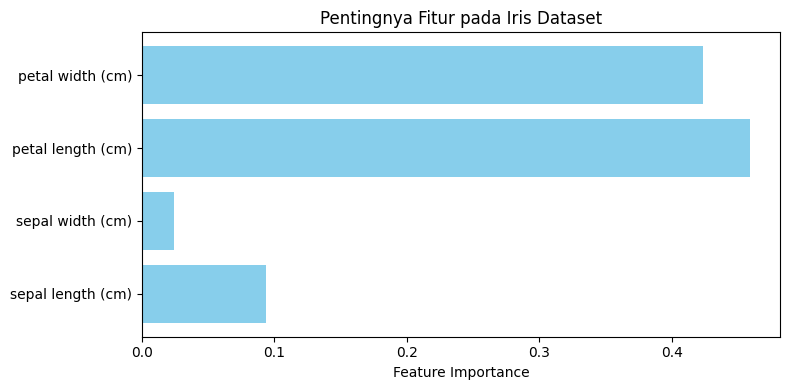

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.barh(iris.feature_names, rf_iris.feature_importances_, color="skyblue")
plt.title("Pentingnya Fitur pada Iris Dataset")
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()


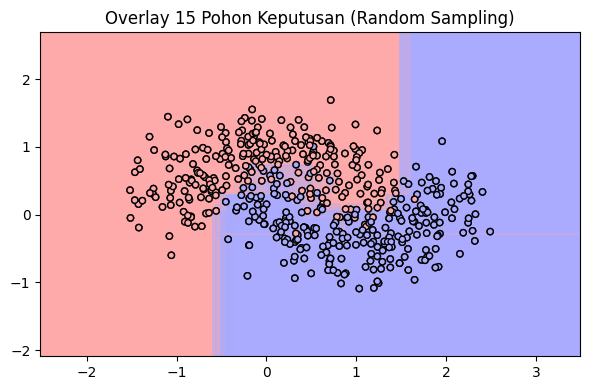

In [ ]:
from sklearn.tree import DecisionTreeClassifier

plt.figure(figsize=(6, 4))

for i in range(15):
    # Sampling dengan replacement (bootstrap)
    idxs = np.random.randint(0, len(X_train), len(X_train))
    X_sample = X_train[idxs]
    y_sample = y_train[idxs]

    tree = DecisionTreeClassifier(max_leaf_nodes=16, random_state=123 + i)
    tree.fit(X_sample, y_sample)

    # Gunakan fungsi sebelumnya untuk plot
    tampilkan_boundary(tree, X, y, ax=plt.gca(), title="")

plt.title("Overlay 15 Pohon Keputusan (Random Sampling)")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X_mnist = mnist.data
y_mnist = mnist.target.astype(np.uint8)


In [ ]:
from tensorflow.keras.datasets import mnist
import numpy as np

# load MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# gabungkan train + test jadi satu dataset seperti openml mnist_784
X_mnist = np.vstack([X_train.reshape(-1, 784), X_test.reshape(-1, 784)])
y_mnist = np.hstack([y_train, y_test])

print(X_mnist.shape, y_mnist.shape)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(70000, 784) (70000,)


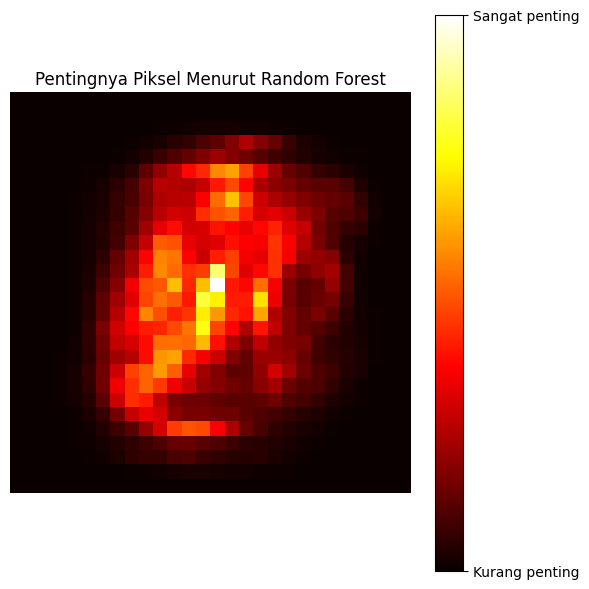

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib as mpl
import matplotlib.pyplot as plt

# 1. Flatten data (karena RandomForest tidak menerima input 3D)
X_train_flat = X_train.reshape(len(X_train), -1)
X_test_flat = X_test.reshape(len(X_test), -1)

# 2. Train Random Forest
clf_rf = RandomForestClassifier(n_estimators=500, random_state=42)
clf_rf.fit(X_train_flat, y_train)

# 3. Fungsi heatmap
def tampilkan_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=mpl.cm.hot, interpolation="nearest")
    plt.axis("off")

# 4. Plot feature importance
plt.figure(figsize=(6, 6))
tampilkan_digit(clf_rf.feature_importances_)

cbar = plt.colorbar(
    ticks=[clf_rf.feature_importances_.min(), clf_rf.feature_importances_.max()]
)
cbar.ax.set_yticklabels(['Kurang penting', 'Sangat penting'])

plt.title("Pentingnya Piksel Menurut Random Forest")
plt.tight_layout()
plt.show()


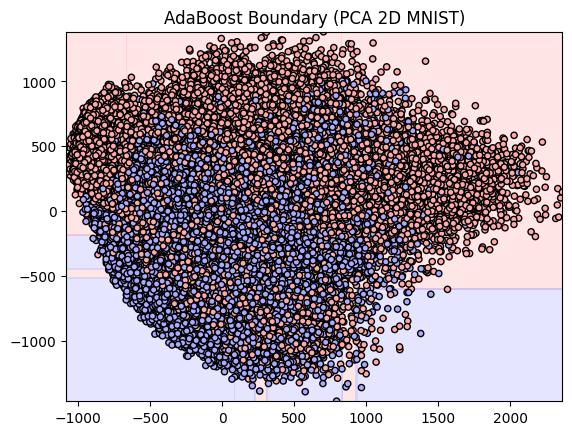

In [ ]:
from sklearn.decomposition import PCA

# Kompres MNIST menjadi 2 fitur
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train_flat)

# Latih AdaBoost pada data 2D
ada_model_2d = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=200,
    learning_rate=0.5,
    random_state=123
)

ada_model_2d.fit(X_train_2d, y_train)

# Tampilkan boundary
tampilkan_boundary(
    ada_model_2d,
    X_train_2d,
    y_train,
    ax=plt.gca(),
    title="AdaBoost Boundary (PCA 2D MNIST)"
)


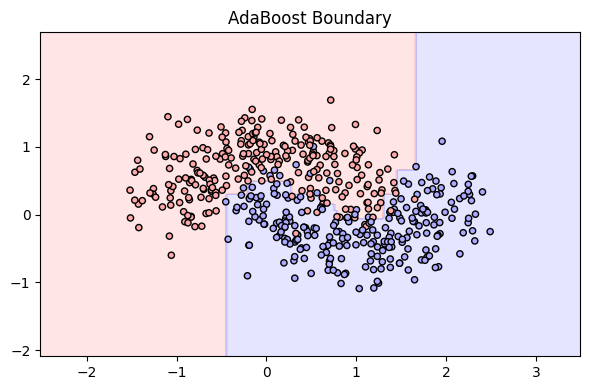

In [ ]:
ada_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=200,
    learning_rate=0.5,
    random_state=123
)

ada_model.fit(X, y)

plt.figure(figsize=(6, 4))
tampilkan_boundary(ada_model, X, y, ax=plt.gca(),
                   title="AdaBoost Boundary")
plt.tight_layout()
plt.show()


In [ ]:
np.random.seed(123)
X_reg = np.random.rand(100, 1) - 0.5
y_reg = 3 * (X_reg[:, 0] ** 2) + 0.05 * np.random.randn(100)


In [ ]:
from sklearn.tree import DecisionTreeRegressor

# Tree pertama: belajar dari y langsung
tree1 = DecisionTreeRegressor(max_depth=2, random_state=123)
tree1.fit(X_reg, y_reg)

# Tree kedua: belajar dari residual
res1 = y_reg - tree1.predict(X_reg)
tree2 = DecisionTreeRegressor(max_depth=2, random_state=456)
tree2.fit(X_reg, res1)

# Tree ketiga: belajar dari residual sebelumnya
res2 = res1 - tree2.predict(X_reg)
tree3 = DecisionTreeRegressor(max_depth=2, random_state=789)
tree3.fit(X_reg, res2)


DecisionTreeRegressor(max_depth=2, random_state=789)

In [ ]:
X_new = np.array([[0.8]])
y_pred_gb_manual = sum(tree.predict(X_new) for tree in (tree1, tree2, tree3))
print(f"Prediksi Gradient Boosting Manual untuk x=0.8: {y_pred_gb_manual[0]:.4f}")


Prediksi Gradient Boosting Manual untuk x=0.8: 0.7034


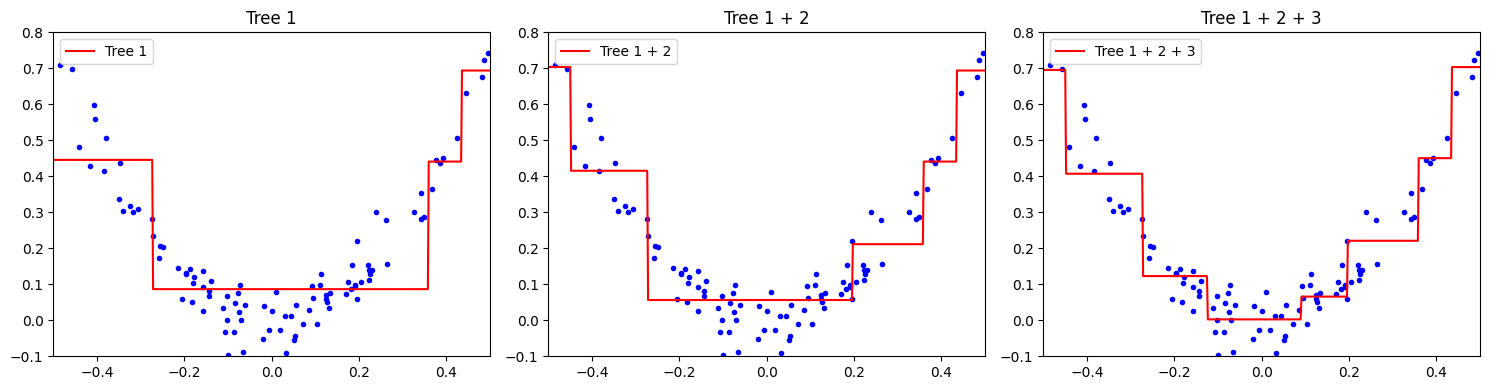

In [ ]:
def plot_boosting_progress(trees, X, y, ax, label=None):
    x_grid = np.linspace(-0.5, 0.5, 500).reshape(-1, 1)
    y_total = sum(tree.predict(x_grid) for tree in trees)
    ax.plot(X, y, "b.")
    ax.plot(x_grid, y_total, "r-", label=label)
    ax.set_title(label or "Boosting Step")
    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.1, 0.8)
    if label:
        ax.legend()

fig, axs = plt.subplots(1, 3, figsize=(15, 4))
plot_boosting_progress([tree1], X_reg, y_reg, axs[0], label="Tree 1")
plot_boosting_progress([tree1, tree2], X_reg, y_reg, axs[1], label="Tree 1 + 2")
plot_boosting_progress([tree1, tree2, tree3], X_reg, y_reg, axs[2], label="Tree 1 + 2 + 3")
plt.tight_layout()
plt.show()


## Mengguankan Early Stopping

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbr_fast = GradientBoostingRegressor(
    max_depth=2,
    n_estimators=3,
    learning_rate=1.0,
    random_state=123
)

gbr_fast.fit(X_reg, y_reg)


GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=123)

In [ ]:
gbr_slow = GradientBoostingRegressor(
    max_depth=2,
    n_estimators=200,
    learning_rate=0.1,
    random_state=123
)
gbr_slow.fit(X_reg, y_reg)


GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=123)

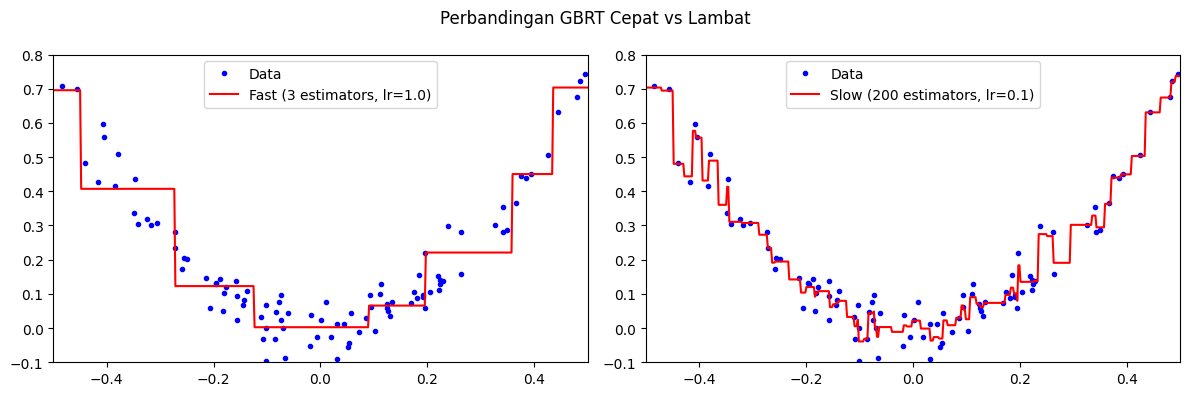

In [ ]:
def plot_boost_model(model, ax, label):
    x_lin = np.linspace(-0.5, 0.5, 500).reshape(-1, 1)
    y_pred = model.predict(x_lin)
    ax.plot(X_reg, y_reg, "b.", label="Data")
    ax.plot(x_lin, y_pred, "r-", label=label)
    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.1, 0.8)
    ax.legend()

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plot_boost_model(gbr_fast, axs[0], "Fast (3 estimators, lr=1.0)")
plot_boost_model(gbr_slow, axs[1], "Slow (200 estimators, lr=0.1)")
plt.suptitle("Perbandingan GBRT Cepat vs Lambat")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train_gb, X_val_gb, y_train_gb, y_val_gb = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)


In [ ]:
gbr_full = GradientBoostingRegressor(
    max_depth=2,
    n_estimators=120,
    random_state=123
)
gbr_full.fit(X_train_gb, y_train_gb)

# MSE tiap estimator di validation
errors = [mean_squared_error(y_val_gb, y_pred)
          for y_pred in gbr_full.staged_predict(X_val_gb)]


In [ ]:
best_n = np.argmin(errors) + 1
print(f"Estimator optimal: {best_n}")

gbr_best = GradientBoostingRegressor(
    max_depth=2,
    n_estimators=best_n,
    random_state=123
)
gbr_best.fit(X_train_gb, y_train_gb)


Estimator optimal: 50


GradientBoostingRegressor(max_depth=2, n_estimators=np.int64(50),
                          random_state=123)

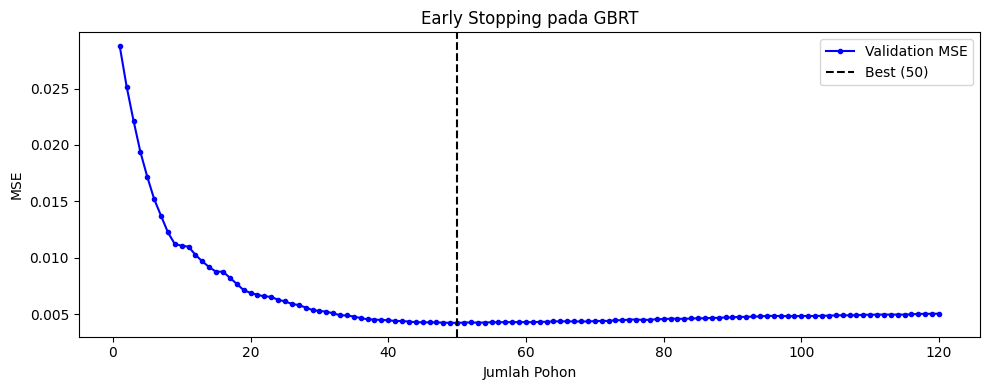

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(np.arange(1, len(errors) + 1), errors, "b.-", label="Validation MSE")
plt.axvline(best_n, color="k", linestyle="--", label=f"Best ({best_n})")
plt.xlabel("Jumlah Pohon")
plt.ylabel("MSE")
plt.title("Early Stopping pada GBRT")
plt.legend()
plt.tight_layout()
plt.show()


## Tanpa Early Stopping

In [ ]:
gbr_no_early = GradientBoostingRegressor(
    max_depth=2,
    n_estimators=200,      # Lebih besar dari optimal
    learning_rate=0.1,
    random_state=123
)
gbr_no_early.fit(X_train_gb, y_train_gb)


GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=123)

In [ ]:
from sklearn.metrics import mean_squared_error

y_val_pred_full = gbr_no_early.predict(X_val_gb)
val_error_full = mean_squared_error(y_val_gb, y_val_pred_full)

print(f"MSE model tanpa early stopping (200 pohon): {val_error_full:.6f}")


MSE model tanpa early stopping (200 pohon): 0.005981


In [ ]:
y_val_pred_best = gbr_best.predict(X_val_gb)
val_error_best = mean_squared_error(y_val_gb, y_val_pred_best)

print(f"MSE model early stopping ({best_n} pohon): {val_error_best:.6f}")


MSE model early stopping (50 pohon): 0.004222


In [ ]:
from xgboost import XGBRegressor

xgb_reg = XGBRegressor(
    n_estimators=200,
    random_state=123,
    tree_method="hist"
)

xgb_reg.fit(X_train_gb, y_train_gb);


In [ ]:
from sklearn.metrics import mean_squared_error

y_val_pred_xgb = xgb_reg.predict(X_val_gb)
val_error_xgb = mean_squared_error(y_val_gb, y_val_pred_xgb)

print(f"MSE XGBoost (200 pohon): {val_error_xgb:.6f}")


MSE XGBoost (200 pohon): 0.007350


In [ ]:
import xgboost
from sklearn.metrics import mean_squared_error

# 1. Masukkan early_stopping_rounds DI SINI (saat pembuatan model), bukan di .fit()
xgb_reg_es = xgboost.XGBRegressor(
    n_estimators=500,
    random_state=123,
    early_stopping_rounds=10  # <--- Pindahkan ke sini
)

# 2. Panggil .fit() tanpa parameter early_stopping_rounds
xgb_reg_es.fit(
    X_train_gb, y_train_gb,
    eval_set=[(X_val_gb, y_val_gb)],
    verbose=False
)

# 3. Prediksi dan Evaluasi
y_val_pred_es = xgb_reg_es.predict(X_val_gb)
val_error_es = mean_squared_error(y_val_gb, y_val_pred_es)

print(f"MSE XGBoost (early stopping): {val_error_es:.6f}")

# Catatan: Di versi baru, atribut best_iteration mungkin tidak langsung tersedia
# jika early stopping tidak terpicu, atau namanya berbeda.
# Namun biasanya atribut ini masih ada jika early stopping aktif.
if hasattr(xgb_reg_es, 'best_iteration'):
    print(f"Best iteration: {xgb_reg_es.best_iteration + 1}")

MSE XGBoost (early stopping): 0.005220
Best iteration: 8


# Exercise

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import fetch_openml

# Load MNIST (jika belum)
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

# Bagi data menjadi train, val, dan test
X_temp, X_eval, y_temp, y_eval = train_test_split(mnist.data, mnist.target, test_size=10000, random_state=123)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=10000, random_state=123)

# Buat model-model individual
clf_rf = RandomForestClassifier(n_estimators=100, random_state=123)
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=123)
clf_svm = LinearSVC(max_iter=100, tol=20, random_state=123)
clf_mlp = MLPClassifier(random_state=123)

models = [clf_rf, clf_et, clf_svm, clf_mlp]

for model in models:
    print(f"Latih: {model.__class__.__name__}")
    model.fit(X_train, y_train)

[val_model.score(X_valid, y_valid) for val_model in models]


Latih: RandomForestClassifier
Latih: ExtraTreesClassifier
Latih: LinearSVC
Latih: MLPClassifier


[0.9662, 0.9683, 0.0994, 0.9617]

In [ ]:
ensemble_all = VotingClassifier(
    estimators=[
        ("rf", clf_rf),
        ("et", clf_et),
        ("svm", clf_svm),
        ("mlp", clf_mlp)
    ],
    voting="hard"
)
ensemble_all.fit(X_train, y_train)


VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=123)),
                             ('et', ExtraTreesClassifier(random_state=123)),
                             ('svm',
                              LinearSVC(max_iter=100, random_state=123,
                                        tol=20)),
                             ('mlp', MLPClassifier(random_state=123))])

In [56]:
import numpy as np

# Prediksi dari masing-masing model di validation set
X_valid_blend = np.zeros((len(X_valid), len(models)), dtype=np.float32)

for idx, model in enumerate(models):
    X_valid_blend[:, idx] = model.predict(X_valid)


In [57]:
from sklearn.ensemble import RandomForestClassifier

blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=123)
blender.fit(X_valid_blend, y_valid)

print("OOB Score blender:", blender.oob_score_)


OOB Score blender: 0.9677


In [58]:
# Prediksi test set dari semua model untuk stacking
X_test_blend = np.zeros((len(X_eval), len(models)), dtype=np.float32)

for idx, model in enumerate(models):
    X_test_blend[:, idx] = model.predict(X_eval)

from sklearn.metrics import accuracy_score

y_pred_blend = blender.predict(X_test_blend)
print("Akurasi blender (stacking) di test set:", accuracy_score(y_eval, y_pred_blend))


Akurasi blender (stacking) di test set: 0.9712


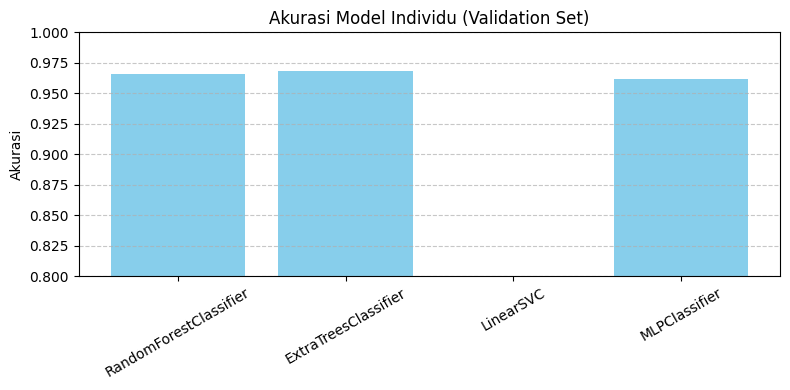

In [59]:
import matplotlib.pyplot as plt

# Buat nama dan skor untuk plot
model_names = [model.__class__.__name__ for model in models]
val_scores = [model.score(X_valid, y_valid) for model in models]

plt.figure(figsize=(8, 4))
plt.bar(model_names, val_scores, color='skyblue')
plt.title("Akurasi Model Individu (Validation Set)")
plt.ylabel("Akurasi")
plt.ylim(0.8, 1.0)
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [60]:
from sklearn.ensemble import VotingClassifier

# Definisikan Voting Classifier TANPA SVM
ensemble_wo_svm = VotingClassifier(
    estimators=[
        ("rf", clf_rf),
        ("et", clf_et),
        # ("svm", clf_svm),  <-- Bagian ini dihapus/dikomentari
        ("mlp", clf_mlp)
    ],
    voting="hard"
)

# Latih modelnya
ensemble_wo_svm.fit(X_train, y_train)

VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=123)),
                             ('et', ExtraTreesClassifier(random_state=123)),
                             ('mlp', MLPClassifier(random_state=123))])

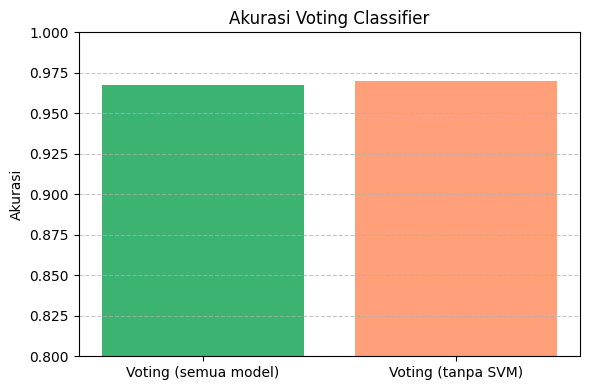

In [61]:
import matplotlib.pyplot as plt

voting_names = ['Voting (semua model)', 'Voting (tanpa SVM)']
voting_scores = [
    ensemble_all.score(X_valid, y_valid),
    ensemble_wo_svm.score(X_valid, y_valid)
]

plt.figure(figsize=(6, 4))
plt.bar(voting_names, voting_scores, color=['#3cb371', '#ffa07a'])
plt.title("Akurasi Voting Classifier")
plt.ylabel("Akurasi")
# Sesuaikan limit Y agar perbedaan terlihat jelas (misal 0.8 sampai 1.0 atau sesuai hasilmu)
plt.ylim(0.8, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

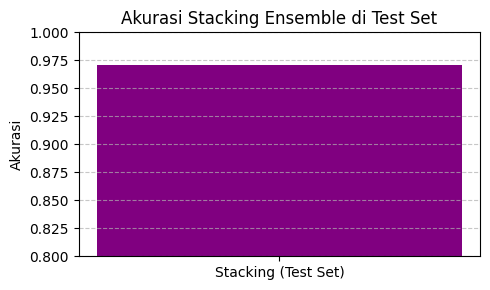

In [62]:
plt.figure(figsize=(5, 3))
plt.bar(["Stacking (Test Set)"], [accuracy_score(y_eval, y_pred_blend)], color='purple')
plt.title("Akurasi Stacking Ensemble di Test Set")
plt.ylim(0.8, 1.0)
plt.ylabel("Akurasi")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
